# IMDB & Embedding

Sentiment analysis on the IMDB data base with pretrained embeddings, RNN, LSTM cell, etc.

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow import keras 
from tensorflow.keras import layers
import keras_tuner as kt
import tensorflow_hub as hub

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Test GPU

In [2]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"KerasTuner Version: {kt.__version__}")

print('\nDevice name:')
print(tf.test.gpu_device_name())

print('\nList physical devices:')
print(tf.config.list_physical_devices('GPU'))

# Returns whether TensorFlow was built with 
# GPU (CUDA or ROCm) support
print('\nwith GPU (CUDA or ROCm) support?')
print(tf.test.is_built_with_gpu_support())

# Returns whether TensorFlow was built with 
# CUDA (GPU) support
print('\nwith CUDA (GPU) support?')
print(tf.test.is_built_with_cuda())


TensorFlow Version: 2.7.0
KerasTuner Version: 1.1.0

Device name:
/device:GPU:0

List physical devices:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

with GPU (CUDA or ROCm) support?
True

with CUDA (GPU) support?
True


# My functions

In [3]:
def plot_loss_acc(history_dict):
    # Function to plot losses and accuracies

    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]

    epochs = range(1, len(loss_values) + 1)
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axes[0].plot(epochs, loss_values, "bo-", label="Training loss")
    axes[0].plot(epochs, val_loss_values, "rv-", label="Validation loss")
    axes[0].set_title("Model loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    # Accuracy
    axes[1].plot(epochs, acc, "bo-", label="Training acc")
    axes[1].plot(epochs, val_acc, "rv-", label="Validation acc")
    axes[1].set_title("Model accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    #
    plt.show()

# Load data

In [4]:
# num_words: integer or "None" (Default = "None" = all words are kept)
# Words are ranked by how often they occur (in the training set) and only the 
# "num_words" most frequent words are kept. Any less frequent word will appear
# as "oov_char" value in the sequence data.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Retrieves a dict mapping words to their index in the IMDB dataset.
# (word_index dictionary: keys are word strings, values are their index)
word_index = imdb.get_word_index()

# Explore the data

In [5]:
print(f"len: {len(word_index)}")
print(f"First 5 items: {list(word_index.items())[0:5]}")
print(f"First key:   {list(word_index.keys())[0]}")
print(f"First item:  {list(word_index.items())[0]}")
print(f"First value: {word_index['fawn']}")


len: 88584
First 5 items: [('fawn', 34701), ('tsukino', 52006), ('nunnery', 52007), ('sonja', 16816), ('vani', 63951)]
First key:   fawn
First item:  ('fawn', 34701)
First value: 34701


Structure of training data

In [6]:
print(f"type: {type(train_data)}")
print(f"shape: {train_data.shape}")
print(f"len train_data: {len(train_data)}")

print(f"\ntype train_data[0]: {type(train_data[0])}")
print(f"len train_data[0]: {len(train_data[0])}")

print("\nFirst 10 element in the first list:")
print(f"{train_data[0][0:9]}")

print(f"\ntrain_labels[0]: {train_labels[0]}")

print(f'\nmin word index: {min([min(sequence) for sequence in train_data])}')
print(f'max word index: {max([max(sequence) for sequence in train_data])}')

type: <class 'numpy.ndarray'>
shape: (25000,)
len train_data: 25000

type train_data[0]: <class 'list'>
len train_data[0]: 218

First 10 element in the first list:
[1, 14, 22, 16, 43, 530, 973, 1622, 1385]

train_labels[0]: 1

min word index: 1
max word index: 9999


In [7]:
print(len(train_labels))
print(train_labels[:100])

25000
[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0]


Structure of word_index

In [8]:
print(f"First 10 keys: {list(word_index.keys())[1:10]}")
print(f"First 10 values: {list(word_index.values())[1:10]}")

print(f"\nValue 52006 is in position: {list(word_index.values()).index(52006)}")
print(f"Value 52006 correspond to key: {list(word_index.keys())[list(word_index.values()).index(52006)]}")

print(f"\nValue 52007 is in position: {list(word_index.values()).index(52007)}")
print(f"Value 52007 correspond to key: {list(word_index.keys())[list(word_index.values()).index(52007)]}")

print(f"\nValue 1 is in position: {list(word_index.values()).index(1)}")
print(f"Value 1 correspond to key: {list(word_index.keys())[list(word_index.values()).index(1)]}")

print(f"\nValue 2 is in position: {list(word_index.values()).index(2)}")
print(f"Value 2 correspond to key: {list(word_index.keys())[list(word_index.values()).index(2)]}")

print(f"\nValue 3 is in position: {list(word_index.values()).index(3)}")
print(f"Value 3 correspond to key: {list(word_index.keys())[list(word_index.values()).index(3)]}")

First 10 keys: ['tsukino', 'nunnery', 'sonja', 'vani', 'woods', 'spiders', 'hanging', 'woody', 'trawling']
First 10 values: [52006, 52007, 16816, 63951, 1408, 16115, 2345, 2289, 52008]

Value 52006 is in position: 1
Value 52006 correspond to key: tsukino

Value 52007 is in position: 2
Value 52007 correspond to key: nunnery

Value 1 is in position: 58318
Value 1 correspond to key: the

Value 2 is in position: 64304
Value 2 correspond to key: and

Value 3 is in position: 37291
Value 3 correspond to key: a


In [9]:
# Default parameters to keras.datasets.imdb.load_data
pad_char = 0
start_char = 1
oov_char = 2
index_from = 3  # Index actual words with this index and higher. 

# Decode one of these reviews back to English words
reverse_word_index = dict((index + index_from, word) for (word, index) in word_index.items())
reverse_word_index[pad_char] = "[PAD]"
reverse_word_index[start_char] = "[START]"
reverse_word_index[oov_char] = "[OOV]"

Due to the default parameters, in `train_data` the value 1 correspond to `[START]` and 2 correspond to `[OOV]`,
and the indexing of the words starts with the value (index) 3.

In `word_index`, the indexing of the words starts with the value (index) 1.

Thus, when creating `reverse_word_index`, the values (index) in `word_index` must be "shifted" by 3.

In `word_index` the value 1 correspond to the key (word) "the", but
in `reverse_word_index` the value (word) "the" correspond to the key 4.

In `reverse_word_index`, value 1 is `[START]` and 2 is `[OOV]`.

I don't understand why, but value 3 is NOT used!?

In [10]:
print(f"First 10 keys: {list(reverse_word_index.keys())[1:10]}")
print(f"First 10 values: {list(reverse_word_index.values())[1:10]}")

print(f"\nValue 'tsukino' is in position: {list(reverse_word_index.values()).index('tsukino')}")
print(f"Value 'tsukino' correspond to key: {list(reverse_word_index.keys())[list(reverse_word_index.values()).index('tsukino')]}")

print("\nIn reverse_word_index:")
print(f"Key 0 correspond to value: {reverse_word_index[0]}")
print(f"Key 1 correspond to value: {reverse_word_index[1]}")
print(f"Key 2 correspond to value: {reverse_word_index[2]}")
# print(f"Key 3 correspond to value: {reverse_word_index[3]}")
print(f"Key 4 correspond to value: {reverse_word_index[4]}")

print("\nIn reverse_word_index:")
print(f"Value '[PAD]' is in position: {list(reverse_word_index.values()).index('[PAD]')}")
print(f"Value '[START]' is in position: {list(reverse_word_index.values()).index('[START]')}")
print(f"Value '[OOV]' is in position: {list(reverse_word_index.values()).index('[OOV]')}")
print(f"Value 'the' is in position: {list(reverse_word_index.values()).index('the')}")

print("\nIn word_index:")
print(f"Value 1 is in position: {list(word_index.values()).index(1)}")
print(f"Value 1 correspond to key: {list(word_index.keys())[list(word_index.values()).index(1)]}")

print(f"\nlength of word_index: {len(word_index.values())}")
print(f"length of reverse_word_index: {len(reverse_word_index.values())} (= 3 additional values: '[PAD]', '[START]' and '[OOV]')")

First 10 keys: [52009, 52010, 16819, 63954, 1411, 16118, 2348, 2292, 52011]
First 10 values: ['tsukino', 'nunnery', 'sonja', 'vani', 'woods', 'spiders', 'hanging', 'woody', 'trawling']

Value 'tsukino' is in position: 1
Value 'tsukino' correspond to key: 52009

In reverse_word_index:
Key 0 correspond to value: [PAD]
Key 1 correspond to value: [START]
Key 2 correspond to value: [OOV]
Key 4 correspond to value: the

In reverse_word_index:
Value '[PAD]' is in position: 88584
Value '[START]' is in position: 88585
Value '[OOV]' is in position: 88586
Value 'the' is in position: 58318

In word_index:
Value 1 is in position: 58318
Value 1 correspond to key: the

length of word_index: 88584
length of reverse_word_index: 88587 (= 3 additional values: '[PAD]', '[START]' and '[OOV]')


`reverse_word_index` has 3 additional values (i.e.,`[PAD]`, `[START]` and `[OOV]`) comapred to `word_index`

In [11]:
# Decode the first sequence in the dataset
decoded_review = " ".join(reverse_word_index[i] for i in train_data[0])
print(decoded_review)

[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [OOV] is an amazing actor and now the same being director [OOV] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [OOV] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [OOV] to the two little boy's that played the [OOV] of norman and paul they were just brilliant children are often left out of the [OOV] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

# Baseline model

Prepare data

In [12]:
# Function to vectorize the data
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

# Vectorize the data
x_train_val = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train_val = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

# the first 10,000 sentences are in the validation set
# the rest is in the training set
n_train_val_split = 10000

x_val = x_train_val[:n_train_val_split]
x_train = x_train_val[n_train_val_split:]
y_val = y_train_val[:n_train_val_split]
y_train = y_train_val[n_train_val_split:]

print(f"Shape x_train: {x_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape x_val: {x_val.shape}")
print(f"Shape y_val: {y_val.shape}")
print(f"Shape x_test: {x_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape x_train: (15000, 10000)
Shape y_train: (15000,)
Shape x_val: (10000, 10000)
Shape y_val: (10000,)
Shape x_test: (25000, 10000)
Shape y_test: (25000,)


In [13]:
model = keras.Sequential()

# First layer
model.add(layers.Dense(16, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation="relu"))
model.add(layers.Dropout(rate=0.5))

# Second layer
model.add(layers.Dense(8, use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation="relu"))
model.add(layers.Dropout(rate=0.5))

# Output layer
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"])

In [14]:
print(f"x_train.shape = {x_train.shape}\n")

model.build(x_train.shape)
print(model.summary())

x_train.shape = (15000, 10000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (15000, 16)               160000    
                                                                 
 batch_normalization (BatchN  (15000, 16)              64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (15000, 16)               0         
                                                                 
 dropout (Dropout)           (15000, 16)               0         
                                                                 
 dense_1 (Dense)             (15000, 8)                128       
                                                                 
 batch_normalization_1 (Batc  (15000, 8)               32        
 hNormalization)        

In [15]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val))

Epoch 1/10
469/469 [==============================] - 5s 6ms/step - loss: 0.5898 - accuracy: 0.6833 - val_loss: 0.4016 - val_accuracy: 0.8398
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.4276 - accuracy: 0.8075 - val_loss: 0.3321 - val_accuracy: 0.8560
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3529 - accuracy: 0.8491 - val_loss: 0.2892 - val_accuracy: 0.8811
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3162 - accuracy: 0.8745 - val_loss: 0.2850 - val_accuracy: 0.8796
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2852 - accuracy: 0.8868 - val_loss: 0.2861 - val_accuracy: 0.8834
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2552 - accuracy: 0.9028 - val_loss: 0.2973 - val_accuracy: 0.8811
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.2467 - accuracy: 0.9051 - val_loss: 0.3065 - val_accuracy: 0.8797
Epoch 

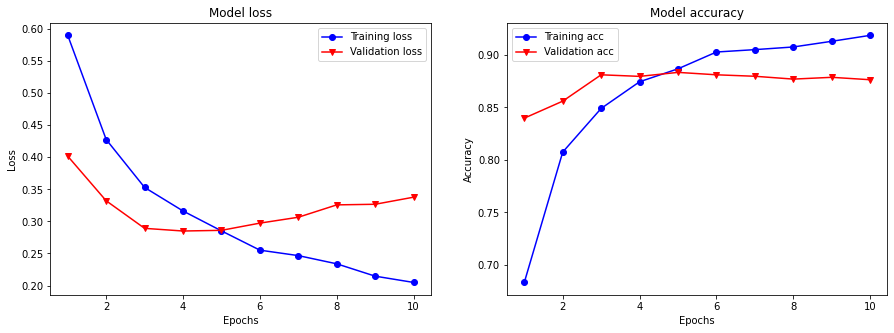

In [16]:
plot_loss_acc(history.history)

In [17]:
print(f"val_accuracy:\n{history.history['val_accuracy']}")

print(f"\nmax value: {max(history.history['val_accuracy'])}")

# Find epoch with highest validation accuracy
max_val = max(history.history['val_accuracy'])
max_index = history.history['val_accuracy'].index(max_val)

print(f"\nmax index: {max_index}")

print(f"\nmax value: {history.history['val_accuracy'][max_index]}")

val_accuracy:
[0.8398000001907349, 0.8560000061988831, 0.8810999989509583, 0.8795999884605408, 0.883400022983551, 0.8810999989509583, 0.8797000050544739, 0.8769999742507935, 0.8787000179290771, 0.8763999938964844]

max value: 0.883400022983551

max index: 4

max value: 0.883400022983551


In [18]:
print(f"Keys: {history.history.keys()}\n")

# Find epoch with highest validation accuracy
max_val = max(history.history['val_accuracy'])
max_index = history.history['val_accuracy'].index(max_val)
max_epoc = max_index + 1 # index starts at 0
print(f"Highest val accuracy: EPOC = {max_epoc}")

scores_model = {'baseline': 
     {'loss': np.round(history.history['loss'][max_index], 3),
      'accuracy': np.round(history.history['accuracy'][max_index], 3),
      'val_loss': np.round(history.history['val_loss'][max_index], 3),
      'val_acc': np.round(history.history['val_accuracy'][max_index], 3)}
    }

print(scores_model)
print(scores_model['baseline'])
print(scores_model['baseline']['val_acc'])


Keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Highest val accuracy: EPOC = 5
{'baseline': {'loss': 0.285, 'accuracy': 0.887, 'val_loss': 0.286, 'val_acc': 0.883}}
{'loss': 0.285, 'accuracy': 0.887, 'val_loss': 0.286, 'val_acc': 0.883}
0.883


# Prepare data (for embedding)

Load pre-trained embedding

In [19]:
emb_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",
    input_shape=[],  # input shape is a list
    dtype=tf.string,
    # set "trainable=True" to perform transfer learning (fine-tune the model)
    trainable=True)

In [20]:
print(f"Shape: {tf.shape(emb_layer.weights)}\n")

print(f"Weights:\n{emb_layer.weights}")

Shape: [     1 963812     50]

Weights:
[<tf.Variable 'Variable:0' shape=(963812, 50) dtype=float32, numpy=
array([[-0.07078403,  0.2309921 , -0.04001201, ...,  0.006042  ,
         0.01584901, -0.23308909],
       [ 0.13103518,  0.17923635,  0.01063039, ..., -0.29381433,
         0.05539819,  0.05226879],
       [ 0.06475412, -0.12864912, -0.12485643, ..., -0.16776969,
         0.07435564,  0.19124678],
       ...,
       [ 0.4045343 , -0.17706504, -0.13003995, ..., -0.01742322,
         0.02578888,  0.29181632],
       [ 0.4186347 ,  0.0406054 , -0.14481059, ..., -0.05217805,
         0.03594268,  0.21899657],
       [ 0.4463733 ,  0.06268543,  0.02524463, ...,  0.17416938,
        -0.11148718,  0.2714855 ]], dtype=float32)>]


Input: 1 word

Output: 50D vector with shape = (1, 50)

In [21]:
emb_test_1 = emb_layer(["Test"])
print(f"shape: {emb_test_1.shape}\n")
print(emb_test_1)

shape: (1, 50)

tf.Tensor(
[[ 0.04776037 -0.06886768 -0.16459087  0.08581819 -0.08490262  0.02099551
  -0.19653788 -0.13598481 -0.04143906 -0.09736596  0.07609851 -0.03156528
   0.10957347  0.24403939  0.09446617 -0.09135689  0.06340048 -0.0389905
   0.24184163  0.05320741  0.0095424  -0.07943342 -0.14991164 -0.04996819
   0.21571031 -0.22749782 -0.11248333  0.15297459 -0.19220279 -0.0400783
  -0.21998696  0.07353514 -0.14533381  0.00502099  0.31326562 -0.25409043
   0.04892169  0.01067351  0.04883608 -0.22023776 -0.08438189  0.08828487
   0.31126228  0.1151011   0.01516471 -0.01142792  0.02667623  0.24145083
  -0.11506686  0.16467647]], shape=(1, 50), dtype=float32)


Two words
Input: 2 word

Output: 50D vectors; shape = (1, 50)

In [22]:
emb_test_1 = emb_layer(["Test this"])
print(f"shape: {emb_test_1.shape}\n")
print(emb_test_1)

shape: (1, 50)

tf.Tensor(
[[ 0.14266299  0.15968978 -0.09341733  0.17129184 -0.17735712 -0.06850743
  -0.18280964  0.10770726 -0.04795001 -0.01782284 -0.00377065  0.00428251
   0.1522757   0.09870012  0.24908243 -0.08882328  0.01074235  0.06888396
   0.09785467 -0.03969875 -0.15062603 -0.06340863  0.07338854 -0.12052223
   0.094575   -0.09007384 -0.35428354  0.2508838  -0.13932143 -0.15338713
  -0.28947982  0.09856007 -0.16252455  0.02747028  0.31612498 -0.16526245
   0.1515378  -0.01131452 -0.09479989 -0.20544472 -0.05588011 -0.01836273
   0.22014242  0.07081797 -0.04668182 -0.12809321 -0.10117901  0.1283879
  -0.07625469  0.06370711]], shape=(1, 50), dtype=float32)


Input: word (as above but reverse order)

Output: 50D vector with shape = (1, 50)

The order matters, so this returns a different vector

In [23]:
emb_test_1 = emb_layer(["This test"])
print(f"shape: {emb_test_1.shape}\n")
print(emb_test_1)

shape: (1, 50)

tf.Tensor(
[[-0.05719313  0.16746423  0.14258622  0.25223008 -0.21868415 -0.17598276
  -0.08619111  0.2312977  -0.20808885 -0.08066375  0.05066421 -0.07521921
   0.18413132 -0.0994789   0.21638936 -0.24349506  0.05405843 -0.18068534
   0.11516805  0.03481622 -0.2888843   0.11657007 -0.08851601  0.00263449
   0.03328478 -0.04782099 -0.11963638  0.07242545 -0.12605622 -0.10390378
  -0.08429206 -0.08616674  0.07709306  0.010702    0.26130664 -0.03748824
   0.13718121 -0.19891232 -0.02172319  0.06137453 -0.07685141  0.03934212
   0.16593252  0.22282104 -0.26778695 -0.11014152 -0.11613198  0.04245697
   0.20837663  0.28455013]], shape=(1, 50), dtype=float32)


Input: word (as above but all low case letters)

Output: 50D vector with shape = (1, 50)

Capital letters also change the output

In [24]:
emb_test_1 = emb_layer(["this test"])
print(f"shape: {emb_test_1.shape}\n")
print(emb_test_1)

shape: (1, 50)

tf.Tensor(
[[ 5.61277792e-02  1.87619686e-01  3.62951793e-02  2.23079309e-01
  -2.14608163e-01 -1.08884692e-01 -5.96119650e-02  2.36398637e-01
  -1.74687982e-01 -9.22392756e-02 -3.94847840e-02 -4.40938808e-02
   2.17820972e-01 -1.40717641e-01  8.16476345e-02 -1.37843594e-01
  -1.45933464e-05  9.87602863e-03  4.82108742e-02  1.17605142e-02
  -2.46757388e-01  1.93484589e-01  2.29739193e-02 -2.70540565e-02
  -1.91590711e-02 -4.37474437e-02 -3.19004416e-01  1.56149268e-01
  -8.89753699e-02 -1.29297107e-01 -1.80213690e-01  2.26528514e-02
   3.15944897e-03  4.22925167e-02  2.73824453e-01 -9.97060463e-02
   1.15635723e-01 -1.81625500e-01 -8.18127021e-02 -2.89397854e-02
  -8.54106247e-02 -2.59958077e-02  2.18336597e-01  2.23693088e-01
  -1.72788933e-01 -2.16245785e-01 -1.30134508e-01  5.83978556e-03
   1.21428356e-01  4.45895158e-02]], shape=(1, 50), dtype=float32)


Input: a sentence

Output: 50D vector with shape = (1, 50)

This pre-trained embedding maps a sentence to its embedding vector, with the following procedure:

1. Split the sentences into tokens
2. Embed each token (word embedding)
3. Combine the word embeddings into a whole embedding (sentence embedding)

In [25]:
emb_test_1 = emb_layer(["This is a test sentece"])
print(f"shape: {emb_test_1.shape}\n")
print(emb_test_1)

shape: (1, 50)

tf.Tensor(
[[ 0.03490218  0.16172831  0.23502909  0.11702017 -0.01992871 -0.19280444
  -0.03032632  0.42247042 -0.17463143  0.11061392 -0.20684198 -0.10816587
  -0.00580655 -0.06549336  0.15517563 -0.30142653 -0.08806028 -0.02007063
   0.06983391 -0.05946058 -0.24798736 -0.11611294  0.06882623  0.11254646
  -0.1325322  -0.11367108 -0.25896594 -0.15688322  0.08890296 -0.14879154
  -0.07682836  0.10784158  0.11499087 -0.00474725  0.09338438 -0.04716892
   0.1573174  -0.08895263  0.17764075  0.05421483 -0.0182819   0.03440694
   0.1152048   0.19914365 -0.42840165 -0.17844574 -0.03394165 -0.01203495
   0.07526059  0.07941826]], shape=(1, 50), dtype=float32)


Input: 3 sentences (as list)

Output: three 50D vector with shape = (3, 50)

In [26]:
emb_test_1 = emb_layer(["live long and prosper", "may the Force be with you", "klaatu barada nikto"])
print(f"shape: {emb_test_1.shape}\n")

shape: (3, 50)



Convert train_data to a list of strings (senetences) and then to a tensor, and create training, validation, and test sets

In [27]:
print(train_data.shape)
print(train_data[:n_train_val_split].shape)
print(train_data[n_train_val_split:].shape)

(25000,)
(10000,)
(15000,)


In [28]:
# Select validation and training data
val_emb = train_data[:n_train_val_split]
train_emb = train_data[n_train_val_split:]
y_train_val_emb = np.asarray(train_labels).astype("float32")

# Validation set
val_data_rev = [" ".join(reverse_word_index[i] for i in sentence) for sentence in val_emb]
x_val_emb = tf.convert_to_tensor(val_data_rev)
y_val_emb = y_train_val_emb[:n_train_val_split]

# Training set
train_data_rev = [" ".join(reverse_word_index[i] for i in sentence) for sentence in train_emb]
x_train_emb = tf.convert_to_tensor(train_data_rev)
y_train_emb = y_train_val_emb[n_train_val_split:]

# Trainig + validation
train_val_data_rev = [" ".join(reverse_word_index[i] for i in sentence) for sentence in train_data]
x_train_val_emb = tf.convert_to_tensor(train_val_data_rev)

# Test set
test_data_rev = [" ".join(reverse_word_index[i] for i in sentence) for sentence in test_data]
x_test_emb = tf.convert_to_tensor(test_data_rev)
y_test_emb = np.asarray(test_labels).astype("float32")

In [29]:
print("train_data", "-"*50)
print(f"type: {type(train_emb)}")
print(f"shape: {train_emb.shape}")
print(f"len: {len(train_emb)}")

print("\ntrain_data_rev", "-"*50)
print(f"type: {type(train_data_rev)}")
print(f"len: {len(train_data_rev)}")

print("\nx_train_emb", "-"*50)
print(f"type: {type(x_train_emb)}")
print(f"shape: {x_train_emb.shape}")

train_data --------------------------------------------------
type: <class 'numpy.ndarray'>
shape: (15000,)
len: 15000

train_data_rev --------------------------------------------------
type: <class 'list'>
len: 15000

x_train_emb --------------------------------------------------
type: <class 'tensorflow.python.framework.ops.EagerTensor'>
shape: (15000,)


In [30]:
print("train_data_rev[0]")
print(train_data_rev[0])

print("\nx_train_emb[0]")
print(x_train_emb[0])

train_data_rev[0]
[START] i think this is one of the weakest of the kenneth branagh [OOV] works after such great efforts as much [OOV] about nothing etc i thought this was poor the cast was weaker alicia [OOV] [OOV] [OOV] but my biggest [OOV] was that they messed with the [OOV] work and cut out some of the play to put in the musical dance sequences br br you just don't do shakespeare and then mess with the play sorry but that is just wrong i love some cole porter just like the next person but [OOV] don't mess with the shakespeare skip this and watch [OOV] books if you want to see a brilliant shakespearean adaptation of the [OOV]

x_train_emb[0]
tf.Tensor(b"[START] i think this is one of the weakest of the kenneth branagh [OOV] works after such great efforts as much [OOV] about nothing etc i thought this was poor the cast was weaker alicia [OOV] [OOV] [OOV] but my biggest [OOV] was that they messed with the [OOV] work and cut out some of the play to put in the musical dance sequences br

In [31]:
print("train_data_rev[0]", "-"*50)
emb_test_2a = emb_layer([train_data_rev[0]])
print(f"shape: {emb_test_2a.shape}\n")
print(emb_test_2a)

print("\nx_train_emb[0]", "-"*50)
emb_test_2b = emb_layer([x_train_emb[0]])
print(f"shape: {emb_test_2b.shape}\n")
print(emb_test_2b)

train_data_rev[0] --------------------------------------------------
shape: (1, 50)

tf.Tensor(
[[ 1.1402115   0.26369712 -0.10565904  0.5127624  -0.09218049 -0.2573422
   0.19137299 -0.2887305  -0.88435674  0.5195096   0.08822305  0.2331015
  -0.09239576  0.13647714 -0.21743007 -0.18493603  0.08253232  0.23226394
   0.06359208 -0.575828   -0.1026831  -0.07140121  0.23901196 -0.04265045
  -0.45965418  0.32664436 -1.2081124   0.1819036   0.29884025 -0.4041018
  -0.3660003   0.07582293  0.6965147  -0.35436007 -0.6583187   0.39987397
   0.4226374  -0.69412565 -0.04035674 -0.96559626  0.17555335  0.2152515
   0.13631134 -0.17444114 -0.38762408 -0.20388247 -0.65234435 -0.3386061
   0.0139037  -0.00602219]], shape=(1, 50), dtype=float32)

x_train_emb[0] --------------------------------------------------
shape: (1, 50)

tf.Tensor(
[[ 1.1402115   0.26369712 -0.10565904  0.5127624  -0.09218049 -0.2573422
   0.19137299 -0.2887305  -0.88435674  0.5195096   0.08822305  0.2331015
  -0.09239576  0.1

# Embedding Model (embedding + dense)

Layers:

1. `emb_layer`: a tensorflow hub layer; it is a pre-trained embedding that maps a sentence to its embedding vector; it (I) splits the sentences into tokens, (II) embeds each token (word embedding), and (III) combines the word embeddings into a whole embedding (sentence embedding). The shape of the output is (num_examples, embedding_dimension), that is (X_train.shape, 50).
4. `Dense`: 16 units, relu activation.
5. `Dense`: output layer, 1 unit, sigmoid activation.

Build the model

In [32]:
model_emb = keras.Sequential()

# Pretrained embedding
model_emb.add(emb_layer)

# 1st Dense layer
model_emb.add(layers.Dense(16, use_bias=False))
model_emb.add(layers.BatchNormalization())
model_emb.add(layers.Activation(activation="relu"))
model_emb.add(layers.Dropout(rate=0.5))

model_emb.add(layers.Dense(1, activation="sigmoid"))

model_emb.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

In [33]:
print(model_emb.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 16)                800       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 16)                0         
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                      

In [34]:
history_emb = model_emb.fit(
    x_train_emb,
    y_train_emb,
    epochs=10,
    batch_size=32,
    validation_data=(x_val_emb, y_val_emb))

Epoch 1/10
469/469 [==============================] - 11s 22ms/step - loss: 0.5296 - accuracy: 0.7361 - val_loss: 0.3280 - val_accuracy: 0.8660
Epoch 2/10
469/469 [==============================] - 10s 22ms/step - loss: 0.3100 - accuracy: 0.8782 - val_loss: 0.2763 - val_accuracy: 0.8849
Epoch 3/10
469/469 [==============================] - 10s 22ms/step - loss: 0.2297 - accuracy: 0.9144 - val_loss: 0.2822 - val_accuracy: 0.8823
Epoch 4/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1857 - accuracy: 0.9333 - val_loss: 0.3125 - val_accuracy: 0.8800
Epoch 5/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1502 - accuracy: 0.9467 - val_loss: 0.3429 - val_accuracy: 0.8729
Epoch 6/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1241 - accuracy: 0.9561 - val_loss: 0.4156 - val_accuracy: 0.8639
Epoch 7/10
469/469 [==============================] - 10s 22ms/step - loss: 0.1105 - accuracy: 0.9604 - val_loss: 0.4381 - val_accuracy:

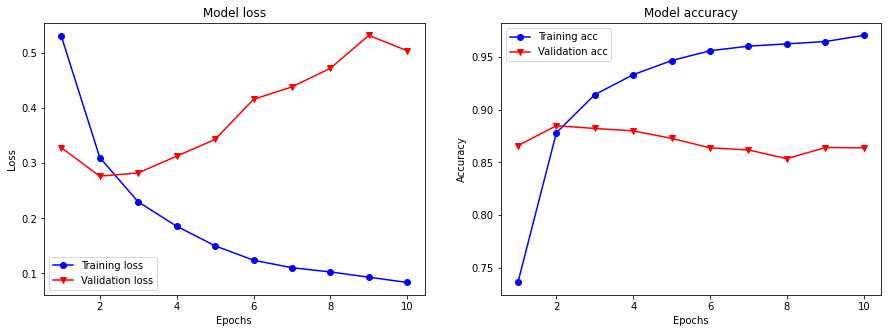

Highest val accuracy: EPOC = 2


In [35]:
# Plot loss and accuracy
plot_loss_acc(history_emb.history)

# Find epoch with highest validation accuracy
max_val_emb = max(history_emb.history['val_accuracy'])
max_index_emb = history_emb.history['val_accuracy'].index(max_val_emb)
max_epoc_emb = max_index_emb + 1 # index starts at 0
print(f"Highest val accuracy: EPOC = {max_epoc_emb}")

# save values
scores_model['emb_model'] = {
    'loss': np.round(history_emb.history['loss'][max_index_emb], 3),
    'accuracy': np.round(history_emb.history['accuracy'][max_index_emb], 3),
    'val_loss': np.round(history_emb.history['val_loss'][max_index_emb], 3),
    'val_acc': np.round(history_emb.history['val_accuracy'][max_index_emb], 3)}


In [36]:
print(f"baseline model =  {scores_model['baseline']}")
print(f"embedding model = {scores_model['emb_model']}")

baseline model =  {'loss': 0.285, 'accuracy': 0.887, 'val_loss': 0.286, 'val_acc': 0.883}
embedding model = {'loss': 0.31, 'accuracy': 0.878, 'val_loss': 0.276, 'val_acc': 0.885}


# Test accuracy

Retrain models on the full data set(training + validation)

In [37]:
model_baseline = keras.Sequential()

# First layer
model_baseline.add(layers.Dense(16, use_bias=False))
model_baseline.add(layers.BatchNormalization())
model_baseline.add(layers.Activation(activation="relu"))
model_baseline.add(layers.Dropout(rate=0.5))

# Second layer
model_baseline.add(layers.Dense(8, use_bias=False))
model_baseline.add(layers.BatchNormalization())
model_baseline.add(layers.Activation(activation="relu"))
model_baseline.add(layers.Dropout(rate=0.5))

# Output layer
model_baseline.add(layers.Dense(1, activation="sigmoid"))

model_baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"])

history = model_baseline.fit(
    x_train_val,
    y_train_val,
    epochs=max_epoc, # epoch with highests val_accuracy
    batch_size=32)

Epoch 1/5
782/782 [==============================] - 3s 4ms/step - loss: 0.5162 - accuracy: 0.7425
Epoch 2/5
782/782 [==============================] - 3s 4ms/step - loss: 0.3754 - accuracy: 0.8402
Epoch 3/5
782/782 [==============================] - 3s 4ms/step - loss: 0.3197 - accuracy: 0.8634
Epoch 4/5
782/782 [==============================] - 3s 4ms/step - loss: 0.2948 - accuracy: 0.8758
Epoch 5/5
782/782 [==============================] - 3s 4ms/step - loss: 0.2630 - accuracy: 0.8882


In [38]:
emb_layer = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-en-dim50/2",
    input_shape=[],  # input shape is a list
    dtype=tf.string,
    # set "trainable=True" to perform transfer learning (fine-tune the model)
    trainable=True)

model_embedding = keras.Sequential()

# Pretrained embedding
model_embedding.add(emb_layer)

# 1st Dense layer
model_embedding.add(layers.Dense(16, use_bias=False))
model_embedding.add(layers.BatchNormalization())
model_embedding.add(layers.Activation(activation="relu"))
model_embedding.add(layers.Dropout(rate=0.5))

model_embedding.add(layers.Dense(1, activation="sigmoid"))

model_embedding.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

history_emb = model_embedding.fit(
    x_train_val_emb,
    y_train_val_emb,
    epochs=max_epoc_emb, # epoch with highests val_accuracy
    batch_size=32)

Epoch 1/2
782/782 [==============================] - 16s 20ms/step - loss: 0.4724 - accuracy: 0.7761
Epoch 2/2
782/782 [==============================] - 15s 20ms/step - loss: 0.2873 - accuracy: 0.8891


In [39]:
test_baseline = model_baseline.evaluate(x_test, y_test, verbose=0)
test_emb_model = model_embedding.evaluate(x_test_emb, y_test_emb, verbose=0)

print(f"Baseline model:  Test loss = {test_baseline[0]:.3f} --- Test accuracy = {test_baseline[1]:.3f}")
print(f"Embedding model: Test loss = {test_emb_model[0]:.3f} --- Test accuracy = {test_emb_model[1]:.3f}")

Baseline model:  Test loss = 0.306 --- Test accuracy = 0.877
Embedding model: Test loss = 0.343 --- Test accuracy = 0.861
